# Motivation

In the previous lecture, we studied linear models of the form
$$
y_i = \mu + \mathbf{x}_i'\bm{\beta} + \epsilon_i
$$
where $\mu$ is the intercept (or bias in machine learning lingo), $\mathbf{x}$ is a 
vector of explanatory variables, and $\epsilon_i$ is an additive error
term that captures any residual variance in $y_i$ not accounted for by the explanatory variables.

We estimated the coefficients using ordinary least squares (OLS), which is equivalent to
minimizing the sum of squared errors,
<a id="eq:OLS:loss"></a>
$$
\tag{1}
L(\mu, \bm{\beta}) = 
    \underbrace{\sum_{i=1}^N \Bigl(
    y_i - \mu - \mathbf{x}_i'\bm{\beta}\Bigr)^2}_{\text{Sum of squared errors}}
$$
The estimates $(\widehat{\mu}, \widehat{\bm{\beta}})$ are then the values that minimize $L(\mu, \bm{\beta})$,
$$
(\widehat{\mu}, \widehat{\bm{\beta}}) = \argmin_{\mu,\bm{\beta}} L(\mu, \bm{\beta})
$$

While OLS is the best linear unbiased estimator (BLUE) under the usual assumption about the errors $\epsilon_i$, the estimated $(\widehat{\mu}, \widehat{\bm{\beta}})$ may not be the best model parameters when it comes to minimizing out-of-sample prediction errors. Whenever our focus is on *prediction* rather than on *inference* about population parameters,
we can often do better than using the loss function from [(1)](#eq:OLS:loss). To this end, we augment the loss function with penalty terms which prevent overfitting and improve out-of-sample prediction, thus making these models more suitable for machine learning applications.



***
# Ridge regression

The first model we study is the Ridge regression, which estimates a linear model but adds a penalty term to the loss function:
$$
L(\mu, \bm{\beta}) = 
    \underbrace{\sum_{i=1}^N \Bigl(
    y_i - \mu - \mathbf{x}_i'\bm{\beta}\Bigr)^2}_{\text{Sum of squared errors}}
    + 
    \underbrace{\alpha \sum_{k=1}^K\beta_k^2}_{\text{L2 penalty}}
$$
Compared to ordinary least squares (OLS) we discussed initially, the penalty term increases the loss, in particular if the estimated coefficients $\bm{\beta}$ are large.
This term is called an L2 penalty because it corresponds to the (squared) L2 vector norm. In many textbooks, you will see the penalty term written as 
$\alpha \|\bm{\beta}\|_2^2$, which is equivalent to the formula used above.

For any $\alpha > 0$, the loss function is increasing in the (absolute) coefficient values, thus the minimum $L$ might be one where the elements of $\bm{\beta}$ are smaller than what they would be with OLS. We therefore say that the Ridge regression applies *regularization* or *shrinkage*.
Note, however, that the intercept $\mu$ is not included in the penalty term, and thus no regularization is applied to it.

Clearly, the regularization strength depends on the value of $\alpha$. For tiny (or zero) $\alpha$, the estimated $\widehat{\bm{\beta}}$ will be close (or identical) to OLS, while for large $\alpha$ the estimated coefficients will be compressed towards zero. In this setting, $\alpha$ is a hyperparameter and we can accordingly use cross-validation to find an "optimal" value. 

Why would we ever want to use Ridge regression given that OLS is the best linear unbiased estimator? It turns out that regularization can help in scenarios where we have a large number of (potentially multicollinear) regressors, in which case OLS is prone to overfitting.

## Example: Polynomial approximation

We illustrate such problems and the benefits of Ridge regression using a highly stylized example. Imagine that we want to approximate a (non-linear) trigonometric function using a high-order polynomial, a setting which is notoriously susceptible to overfitting (also see the previous lecture and workshop for illustrations).
Assume that our model is given by
$$
\begin{aligned}
y_i &= \cos\left( \frac{3}{2}\pi x_i \right) + \epsilon_i \\
    \epsilon_i &\stackrel{\text{iid}}{\sim} \mathcal{N}\left(0, 0.5^2\right)
\end{aligned}
$$
where $\epsilon_i$ as an additive, normally-distributed measurement error term 
with mean $0$ and variance $\frac{1}{4}$.

The true values of $y$ (without measurement error) are computed using the
function `compute_true_y()` which returns $y$ for a given $x$.

In [1]:
import numpy as np

def compute_true_y(x):
    """
    True trigonometric function (without errors)
    """
    return np.cos(1.5 * np.pi * x)

The following code creates a demo sample with $N=200$ observations.

In [2]:
from numpy.random import default_rng

def create_trig_sample(N=200, sigma=0.5, rng=None):
    """
    Create trigonometric relationship sample data for Ridge and Lasso.

    Parameters
    ----------
    N : int
        Sample size.
    sigma : float
        Standard deviation of the normal error term.
    rng : np.random.Generator, optional
        Random number generator.
    """

    # Initialize random number generator
    if rng is None:
        rng = default_rng(seed=1234)

    # Randomly draw explanatory variable x uniformly distributed on [0, 1]
    x = rng.uniform(size=N)

    # Draw errors from normal distribution
    epsilon = rng.normal(scale=sigma, size=N)

    # Compute y, add measurement error
    y = compute_true_y(x) + epsilon

    return x, y

In [3]:
x, y = create_trig_sample()

The next graph visualizes the true relationship and the sample points $(x_i, y_i)$.
For this purpose we first define the function `plot_trig_sample()` which creates the baseline plot used throughout the next few sections.

In [4]:
import matplotlib.pyplot as plt


def plot_trig_sample(x, y):
    """
    Plot the trigonometric relationship sample for Ridge and Lasso
    """
    # Sample scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))
    ax.scatter(x, y, s=20, c='none', edgecolor='steelblue', lw=0.75, label='Sample')

    # Plot true relationship
    xvalues = np.linspace(0.0, 1.0, 101)
    y_true = compute_true_y(xvalues)
    ax.plot(xvalues, y_true, c='black', lw=1.0, label='True function')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.legend(loc='upper right')

    return ax

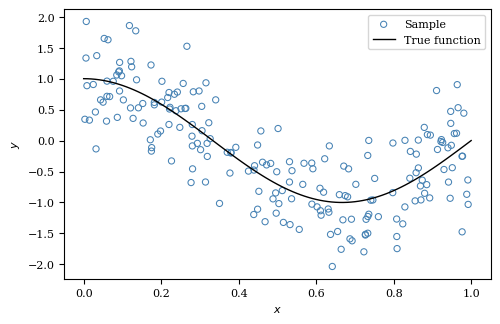

In [5]:
_ = plot_trig_sample(x, y)

## Estimating the Ridge and linear regression models

We now estimate a polynomial approximation where we assume that $y$ is a 
degree-$K$ polynomial in $x$, i.e.,
$$
y_i \approx \mu + \beta_1 x_i + \beta_2 x_i^2 + \cdots + \beta_K x_i^K 
$$
For this example, we choose an unconventionally high $K=15$ since we anticipate that this leads to problems with OLS.

A few more steps are required before we can run the Ridge regression:

- We need to create the polynomial in $x$ which we do with the
[`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) transformation we already encountered.
- Moreover, regularization methods can be susceptible to scaling issues, so we need to demean and normalize all input variables, i.e., we make sure that each feature has mean $0$ and a variance of $1$. We can automate this step using the
[`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
transformation.
- Finally, the estimation step is performed by the [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) class.
- We build a 
[`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
that combines these transformations together with the estimation step. 
We use the function
[`make_pipeline()`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) to simplify this step.

To run the Ridge regression, we moreover need to specify the regularization strength $\alpha$
which we set to $\alpha = 3$ for illustration.

In [6]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

# Polynomial degree
degree = 15

# Build pipeline of transformations and Ridge estimation.
# We create the polynomial transformation w/o the intercept so we 
# need to include an intercept in the fitting step.
pipe_ridge = make_pipeline(
    PolynomialFeatures(
        degree=degree, 
        include_bias=False
    ),
    StandardScaler(),                           # standardize features
    Ridge(alpha=3.0, fit_intercept=True)        # Fit Ridge regression
)

# Make sure X is a matrix
X = x[:, None]

# Fit model
pipe_ridge.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('polynomialfeatures', ...), ('standardscaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"degree degree: int or tuple (min_degree, max_degree), default=2If a single int is given, it specifies the maximal degree of thepolynomial features. If a tuple `(min_degree, max_degree)` is passed,then `min_degree` is the minimum and `max_degree` is the maximumpolynomial degree of the generated features. Note that `min_degree=0`and `min_degree=1` are equivalent as outputting the degree zero term isdetermined by `include_bias`.",15
,"interaction_only interaction_only: bool, default=FalseIf `True`, only interaction features are produced: features that areproducts of at most `degree` *distinct* input features, i.e. terms withpower of 2 or higher of the same input feature are excluded:- included: `x[0]`, `x[1]`, `x[0] * x[1]`, etc.- excluded: `x[0] ** 2`, `x[0] ** 2 * x[1]`, etc.",False
,"include_bias include_bias: bool, default=TrueIf `True` (default), then include a bias column, the feature in whichall polynomial powers are zero (i.e. a column of ones - acts as anintercept term in a linear model).",False
,"order order: {'C', 'F'}, default='C'Order of output array in the dense case. `'F'` order is faster tocompute, but may slow down subsequent estimators... versionadded:: 0.21",'C'
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


It is instructive to estimate the same model using linear regression and compare the results:

In [7]:
from sklearn.linear_model import LinearRegression

# Create pipeline for linear model (linear regression does not require
# standardization!)
pipe_lr = make_pipeline(
    PolynomialFeatures(
        degree=degree, 
        include_bias=False
    ),
    LinearRegression(fit_intercept=True)
)

# Make sure X is a matrix
X = x[:, None]

# Fit model
pipe_lr.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('polynomialfeatures', ...), ('linearregression', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"degree degree: int or tuple (min_degree, max_degree), default=2If a single int is given, it specifies the maximal degree of thepolynomial features. If a tuple `(min_degree, max_degree)` is passed,then `min_degree` is the minimum and `max_degree` is the maximumpolynomial degree of the generated features. Note that `min_degree=0`and `min_degree=1` are equivalent as outputting the degree zero term isdetermined by `include_bias`.",15
,"interaction_only interaction_only: bool, default=FalseIf `True`, only interaction features are produced: features that areproducts of at most `degree` *distinct* input features, i.e. terms withpower of 2 or higher of the same input feature are excluded:- included: `x[0]`, `x[1]`, `x[0] * x[1]`, etc.- excluded: `x[0] ** 2`, `x[0] ** 2 * x[1]`, etc.",False
,"include_bias include_bias: bool, default=TrueIf `True` (default), then include a bias column, the feature in whichall polynomial powers are zero (i.e. a column of ones - acts as anintercept term in a linear model).",False
,"order order: {'C', 'F'}, default='C'Order of output array in the dense case. `'F'` order is faster tocompute, but may slow down subsequent estimators... versionadded:: 0.21",'C'
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06


To illustrate the difference for this artificial example, we add the model predictions from the Ridge and linear regressions to the sample scatter plot we created earlier.

In [8]:
# Grid on which to evaluate predictions
xvalues = np.linspace(np.amin(x), np.amax(x), 100)

# Predicted values from linear regression
y_pred_lr = pipe_lr.predict(xvalues[:, None])

# Predicted values from Ridge regression
y_pred_ridge = pipe_ridge.predict(xvalues[:, None])

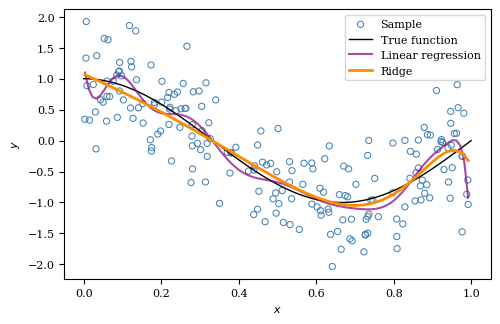

In [9]:
# Plot sample and true relationship
ax = plot_trig_sample(x, y)

# Linear regression prediction
ax.plot(xvalues, y_pred_lr, c='purple', alpha=0.7, label='Linear regression')

# Ridge prediction
ax.plot(xvalues, y_pred_ridge, c='darkorange', lw=2.0, label='Ridge')

_ = ax.legend()

As the graph shows, the OLS model vastly overfits the data which is what we would expect in this settings. Conversely, the prediction of the Ridge regression is reasonably close to the true function and much better behaved despite the high polynomial degree used here.

To gain some intuition for what is going on, it is instructive to plot the estimated Ridge coefficients for a whole range of $\alpha$ values which we do in the code below. 
Note that we choose the grid of $\alpha$ to be uniformly spaced in logs since we want to zoom in on what happens when $\alpha$ is small. This is accomplished by using 
[`np.logspace()`](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html)
instead of `np.linspace()`.

In [10]:
# Create grid of alphas spaced uniformly in logs on [5e-3, 1000]
alphas = np.logspace(start=np.log10(5.0e-3), stop=3, num=100)

# Re-create pipeline w/o Ridge estimator, estimation step differs for each alpha
transform = make_pipeline(
    PolynomialFeatures(degree=degree, include_bias=False), StandardScaler()
)

# Create polynomial features
X_trans = transform.fit_transform(x[:, None])

# Array to store coefficients for all alphas
coefs = np.empty((len(alphas), X_trans.shape[1]))

# Estimate Ridge for each alpha, store fitted coefficients
for i, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha, fit_intercept=True)

    # Fit model for given alpha
    ridge.fit(X_trans, y)

    coefs[i] = ridge.coef_

The following plot shows each coefficient (one color corresponds to one coefficients) for different values of $\alpha$ on the $x$-axis. Note that the $x$-axis is plotted on a $\log_{10}$ scale which allows us to zoom in on smaller values of $\alpha$.

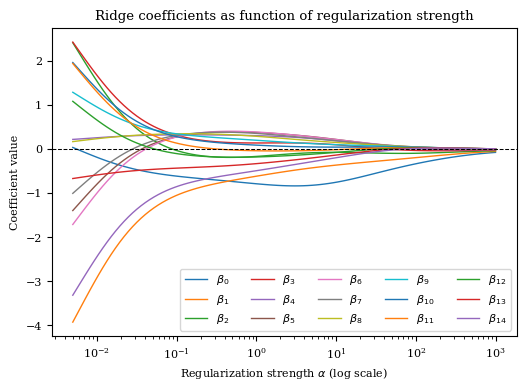

In [11]:
# Plot coefficient arrays against penalty strength
plt.figure(figsize=(6,4))

plt.plot(alphas, coefs, lw=1.0)

plt.xscale('log', base=10)
plt.axhline(0.0, ls='--', lw=0.75, c='black')
plt.xlabel(r'Regularization strength $\alpha$ (log scale)')
plt.ylabel('Coefficient value')
plt.title('Ridge coefficients as function of regularization strength')
_ = plt.legend([rf'$\beta_{{{i}}}$' for i in range(degree)], ncols=5, loc='lower right')

For small $\alpha$ (on the left) the estimated coefficients are close to the (standardized) OLS coefficients, but their values shrink towards zero as $\alpha$ increases. For a very large $\alpha = 10^3$ the estimated coefficients are basically zero since the penalty dominates the sum of squared errors in the loss function.

## Tuning the regularization parameter via cross-validation

In the previous example, we picked an arbitrary regularization strength $\alpha$ when fitting the Ridge regression. In applied work, we would want to tune $\alpha$ (which is a hyperparameter) using cross-validation instead. To this end, we could use the generic cross-validation functionality we studied in the previous lecture since that one works for all types of estimators. However, `scikit-learn` implements a cross-validation class specifically for Ridge regression called
[`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
which we use in the code below to find an optimal $\alpha$.

In [12]:
from sklearn.linear_model import RidgeCV

# RidgeCV does not support pipelines, so we need to transform x before
# cross-validation.
transform = make_pipeline(
    PolynomialFeatures(
        degree=degree, 
        include_bias=False
    ),
    StandardScaler()
)

# Create standardized polynomial features
X_trans = transform.fit_transform(x[:, None])

# Candidate alphas on used for cross-validation. 
# Spaced uniformly in logs to get denser grid for small alphas.
N_alphas = 100
alphas = np.logspace(start=np.log10(1.0e-5), stop=np.log10(5), num=N_alphas)

# Create and run Ridge cross-validation
rcv = RidgeCV(alphas=alphas, store_cv_results=True).fit(X_trans, y)

Note that we don't need to specify the number of folds to be used for cross-validation (this defaults to `cv=None` when creating [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)). In this case, [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) performs the more efficient leave-one-out cross-validation instead of splitting the sample into `n` folds.

By default, [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) uses the (negative) mean squared error (MSE) to find the best $\alpha$ which we can then recover from the `alpha_` attribute. 

In [13]:
# Recover best alpha that minimizes MSE
alpha_best = rcv.alpha_

# Best MSE is stored as negative score!
MSE_best = - rcv.best_score_

print(f'Best alpha: {alpha_best:.3g} (MSE: {MSE_best:.3g})')

Best alpha: 0.00299 (MSE: 0.25)


Because we fitted [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) with the argument `store_cv_results=True`, the fitted object stores the MSE for each `alpha` in `cv_results_` which we can use to plot the MSE as a function of $\alpha$. The dimension of `cv_results_` is `(Nobs, Nalphas)`. Note that this attribute is only available with leave-one-out cross-validation, but not when manually specifying the number of cross-validation folds.

In [14]:
# Compute average MSE for each alpha value across all leave-one-out splits
mse_mean = np.mean(rcv.cv_results_, axis=0)

# Index of MSE-minimizing alpha
imin = np.argmin(mse_mean)

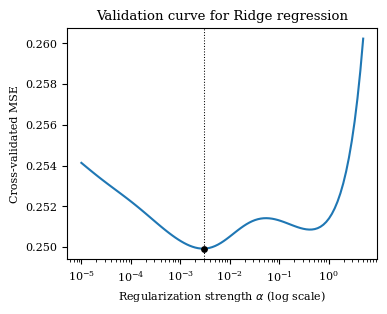

In [15]:
import matplotlib.pyplot as plt

# Plot MSE against alphas, highlight minimum MSE
plt.plot(alphas, mse_mean)
plt.xlabel(r'Regularization strength $\alpha$ (log scale)')
plt.ylabel('Cross-validated MSE')
plt.scatter(alphas[imin], mse_mean[imin], s=15, c='black', zorder=100)
plt.axvline(alphas[imin], ls=':', lw=0.75, c='black')
plt.xscale('log')
_ = plt.title('Validation curve for Ridge regression')

Now that we have identified the optimal $\alpha$, we can re-fit the Ridge regression and plot the prediction from this model. Note that this is not strictly necessary as the return value of [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) can be used to do prediction based on coefficients estimated for the best $\alpha$, but because [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) does not support pipelines, we'd have to apply any transformations manually before doing so.

In [16]:
# Create pipeline with Ridge estimator using optimal alpha
pipe_ridge = make_pipeline(
    PolynomialFeatures(
        degree=degree, 
        include_bias=False
    ),
    StandardScaler(),
    Ridge(alpha=alpha_best, fit_intercept=True)
)

# Fit Ridge regression with optimal alpha
pipe_ridge.fit(x[:, None], y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('polynomialfeatures', ...), ('standardscaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"degree degree: int or tuple (min_degree, max_degree), default=2If a single int is given, it specifies the maximal degree of thepolynomial features. If a tuple `(min_degree, max_degree)` is passed,then `min_degree` is the minimum and `max_degree` is the maximumpolynomial degree of the generated features. Note that `min_degree=0`and `min_degree=1` are equivalent as outputting the degree zero term isdetermined by `include_bias`.",15
,"interaction_only interaction_only: bool, default=FalseIf `True`, only interaction features are produced: features that areproducts of at most `degree` *distinct* input features, i.e. terms withpower of 2 or higher of the same input feature are excluded:- included: `x[0]`, `x[1]`, `x[0] * x[1]`, etc.- excluded: `x[0] ** 2`, `x[0] ** 2 * x[1]`, etc.",False
,"include_bias include_bias: bool, default=TrueIf `True` (default), then include a bias column, the feature in whichall polynomial powers are zero (i.e. a column of ones - acts as anintercept term in a linear model).",False
,"order order: {'C', 'F'}, default='C'Order of output array in the dense case. `'F'` order is faster tocompute, but may slow down subsequent estimators... versionadded:: 0.21",'C'
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


In [17]:
# Grid on which to evaluate predictions
xvalues = np.linspace(np.amin(x), np.amax(x), 100)

# Predicted values from Ridge regression
y_pred = pipe_ridge.predict(xvalues[:, None])

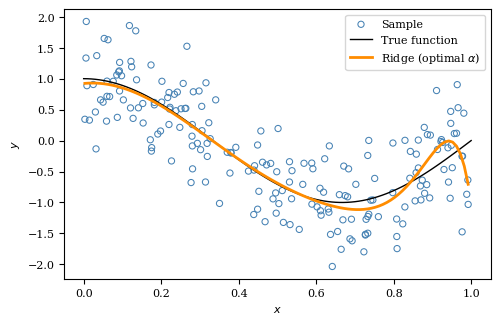

In [18]:
# Plot sample and true relationship
ax = plot_trig_sample(x, y)

# Plot predicted values from cross-validated Ridge regression
ax.plot(xvalues, y_pred, c='darkorange', lw=2.0, label=r'Ridge (optimal $\alpha$)')
_ = ax.legend()

<div style="background-color: #c6dbef; color: #363636; padding: 0.8em 1em 0.5em 1em; border: 1pt solid #363636;">
<h3 style="font-weight: bold;">Your turn</h3>

Rerun the whole Ridge example with a smaller sample size of <i>N=50</i>. What happens to the optimal cross-validated penalty parameter <i>α</i>?
</div>
<span style="display: none;">YourTurnEnd</span>

***
# Lasso

Another widely used estimator with shrinkage is LASSO (least absolute shrinkage and selection operator) which adds an L1 penalty term to the objective function:
$$
L(\mu, \bm{\beta}) = 
    \underbrace{\sum_{i=1}^N \Bigl(
    y_i - \mu - \mathbf{x}_i'\bm{\beta}\Bigr)^2}_{\text{Sum of squared errors}}
    + 
    \underbrace{\alpha \sum_{k=1}^K |\beta_k|}_{\text{L1 penalty}}
$$
As with the Ridge regression, this additional term penalizes large coefficient values.
This term is called an L1 penalty because it corresponds to the L1 vector norm which can equivalently be written as $\alpha \|\bm{\beta}\|_1$.

While the objective looks very similar to Ridge regression, using the L1 instead of the L2 norm can produce much more parsimonious models because many coefficients end up being exactly zero and the corresponding features are thus eliminated from the model. We will see this in the example below.

## Example: Polynomial approximation

We apply Lasso to the same random sample as in the section on Ridge which allows us to compare the two methods. The following code recreates that data, making the same functional form and distributional assumptions as in the previous section.

In [19]:
x, y = create_trig_sample()

## Estimating the Lasso and linear regression models

As with Ridge, we need to standardize the explanatory variables before fitting Lasso. The code below repeats these steps, but we now use 
[`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
to perform the model estimation. For now, we set the regularization strength to $\alpha = 0.0075$ and will use cross-validation to find the optimal value later.

Note that for Lasso it might be necessary to increase the number of iterations by increasing the `max_iter` parameter (from the default of 1,000).

In [20]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

# Polynomial degree
degree = 15

# Build pipeline of transformations and Lasso estimation.
# We create the polynomial transformation w/o the intercept so we 
# need to include an intercept in the fitting step.
pipe_lasso = make_pipeline(
    PolynomialFeatures(
        degree=degree, 
        include_bias=False
    ),
    StandardScaler(),
    Lasso(alpha=0.0075, fit_intercept=True, max_iter=10000)
)

# Make sure X is a matrix
X = x[:, None]

pipe_lasso.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('polynomialfeatures', ...), ('standardscaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"degree degree: int or tuple (min_degree, max_degree), default=2If a single int is given, it specifies the maximal degree of thepolynomial features. If a tuple `(min_degree, max_degree)` is passed,then `min_degree` is the minimum and `max_degree` is the maximumpolynomial degree of the generated features. Note that `min_degree=0`and `min_degree=1` are equivalent as outputting the degree zero term isdetermined by `include_bias`.",15
,"interaction_only interaction_only: bool, default=FalseIf `True`, only interaction features are produced: features that areproducts of at most `degree` *distinct* input features, i.e. terms withpower of 2 or higher of the same input feature are excluded:- included: `x[0]`, `x[1]`, `x[0] * x[1]`, etc.- excluded: `x[0] ** 2`, `x[0] ** 2 * x[1]`, etc.",False
,"include_bias include_bias: bool, default=TrueIf `True` (default), then include a bias column, the feature in whichall polynomial powers are zero (i.e. a column of ones - acts as anintercept term in a linear model).",False
,"order order: {'C', 'F'}, default='C'Order of output array in the dense case. `'F'` order is faster tocompute, but may slow down subsequent estimators... versionadded:: 0.21",'C'
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


For completeness, let's also recreate the linear regression estimation and plot the model predictions alongside the Lasso.

In [21]:
from sklearn.linear_model import LinearRegression

# Create pipeline for linear model (linear regression does not require
# standardization!)
pipe_lr = make_pipeline(
    PolynomialFeatures(
        degree=degree, 
        include_bias=False
    ),
    LinearRegression(fit_intercept=True)
)

# Make sure X is a matrix
X = x[:, None]

pipe_lr.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('polynomialfeatures', ...), ('linearregression', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"degree degree: int or tuple (min_degree, max_degree), default=2If a single int is given, it specifies the maximal degree of thepolynomial features. If a tuple `(min_degree, max_degree)` is passed,then `min_degree` is the minimum and `max_degree` is the maximumpolynomial degree of the generated features. Note that `min_degree=0`and `min_degree=1` are equivalent as outputting the degree zero term isdetermined by `include_bias`.",15
,"interaction_only interaction_only: bool, default=FalseIf `True`, only interaction features are produced: features that areproducts of at most `degree` *distinct* input features, i.e. terms withpower of 2 or higher of the same input feature are excluded:- included: `x[0]`, `x[1]`, `x[0] * x[1]`, etc.- excluded: `x[0] ** 2`, `x[0] ** 2 * x[1]`, etc.",False
,"include_bias include_bias: bool, default=TrueIf `True` (default), then include a bias column, the feature in whichall polynomial powers are zero (i.e. a column of ones - acts as anintercept term in a linear model).",False
,"order order: {'C', 'F'}, default='C'Order of output array in the dense case. `'F'` order is faster tocompute, but may slow down subsequent estimators... versionadded:: 0.21",'C'
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06


The following code plots the sample data, the true functional relationship, and the predictions from the linear regression and Lasso models.

In [22]:
# Grid on which to evaluate predictions
xvalues = np.linspace(np.amin(x), np.amax(x), 100)

# Predicted values from linear regression
y_pred_lr = pipe_lr.predict(xvalues[:, None])

# Predicted values from Lasso regression
y_pred_lasso = pipe_lasso.predict(xvalues[:, None])

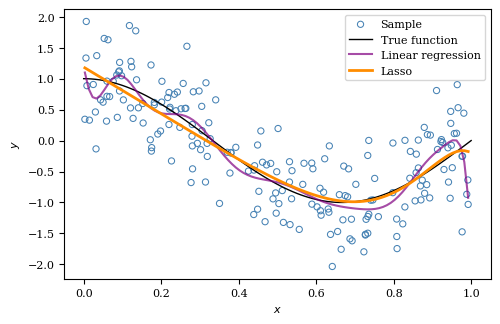

In [23]:
ax = plot_trig_sample(x, y)

# Linear regression prediction
ax.plot(xvalues, y_pred_lr, c='purple', alpha=0.7, label='Linear regression')

# Lasso prediction
ax.plot(xvalues, y_pred_lasso, c='darkorange', lw=2.0, label='Lasso')

_ = ax.legend()

You might be wondering why we chose $\alpha = 0.0075$ whereas we initially used $\alpha = 3$ for the Ridge regression. The reason is that the `scikit-learn` implementation of Lasso uses a slightly different loss function than the one given above, namely
$$
L(\mu, \bm{\beta}) =  \frac{1}{2N}\sum_{i=1}^N \Bigl(
    y_i - \mu - \mathbf{x}_i'\bm{\beta}\Bigr)^2
    + 
    \alpha \|\bm{\beta}\|_1
$$
which scales the sum of squared errors term by a factor of $(2N)^{-1}$. This makes no difference for the optimization, but changes the interpretation of the regularization strength $\alpha$ compared to Ridge regression. For our sample size of $N=200$, an $\alpha_{Ridge}$ used for the [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) estimator approximately corresponds to 
$\alpha_{Lasso} = \frac{\alpha_{Ridge}}{400}$ when plugged into [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

We next fit the model for different values of $\alpha$ on the interval $[10^{-3}, 1]$ where we again space the $\alpha$ uniformly in logs.

In [24]:
# Create grid of alphas spaced uniformly in logs
alphas = np.logspace(start=np.log10(1.0e-3), stop=np.log10(1.0), num=100)

# Re-create pipeline w/o Lasso estimator, estimation step differs for each alpha
transform = make_pipeline(
    PolynomialFeatures(
        degree=degree, 
        include_bias=False
    ),
    StandardScaler()
)

# Create polynomial features
X_trans = transform.fit_transform(x[:, None])

# Array to store coefficients for all alphas
coefs = np.empty((len(alphas), X_trans.shape[1]))

# Estimate Lasso for each alpha, store fitted coefficients
for i, alpha in enumerate(alphas):
    lasso = Lasso(alpha=alpha, 
        fit_intercept=True, 
        max_iter=100_000
    )
    
    # Fit model for given alpha
    lasso.fit(X_trans, y)

    coefs[i] = lasso.coef_

Plotting the fitted coefficients against $\alpha$ on a log scale looks as follows:

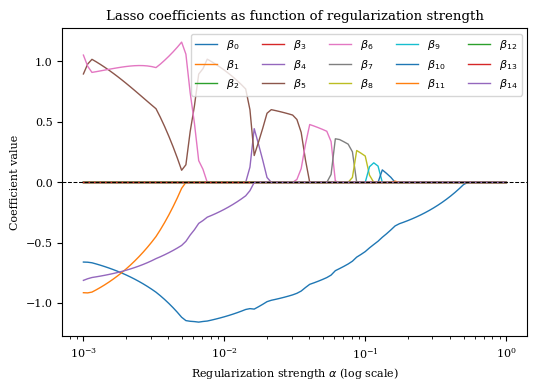

In [25]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, coefs, lw=1.0)
plt.xscale('log', base=10)
plt.axhline(0.0, ls='--', lw=0.75, c='black')
plt.xlabel(r'Regularization strength $\alpha$ (log scale)')
plt.ylabel('Coefficient value')
plt.title('Lasso coefficients as function of regularization strength')
_ = plt.legend([rf'$\beta_{{{i}}}$' for i in range(degree)], ncols=5)

The graph shows that the coefficient estimates are quite different than what we obtained from the Ridge estimator. In fact, most of them are exactly zero for most values of $\alpha$. We highlight this result in the graph below which plots the number of non-zero coefficients against $\alpha$.

In [26]:
# Number of non-zero coefficients for each alpha. 
nonzero = np.sum(np.abs(coefs) > 1.0e-6, axis=1).astype(int)

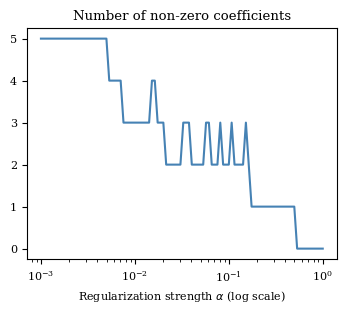

In [27]:
# Plot number of non-zero coefficients against alpha
plt.plot(alphas, nonzero, lw=1.5, c='steelblue')
plt.xscale('log', base=10)
plt.yticks(np.arange(0, np.amax(nonzero) + 1))
plt.xlabel(r'Regularization strength $\alpha$ (log scale)')
_ = plt.title('Number of non-zero coefficients')

Clearly, in this case the model estimated by Lasso is substantially less complex than the linear regression or even Ridge regression. For most values of $\alpha$, only 2–3 features out of the original 15 are retained in the model!

Note that it is possible to compute the path of Lasso coefficients along the grid of $\alpha$ using the convenience function 
[`lasso_path()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lasso_path.html). This function does not support pipelines, so we have to apply any transformations and standardizations to `X` ourselves:

In [28]:
from sklearn.linear_model import lasso_path

# Compute Lasso path automatically
alphas, coefs, _ = lasso_path(X_trans, y, alphas=alphas, max_iter=100_000)

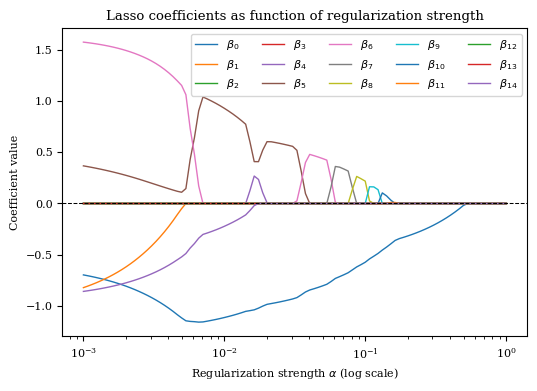

In [29]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, coefs.T, lw=1.0)
plt.xscale('log', base=10)
plt.axhline(0.0, ls='--', lw=0.75, c='black')
plt.xlabel(r'Regularization strength $\alpha$ (log scale)')
plt.ylabel('Coefficient value')
plt.title('Lasso coefficients as function of regularization strength')
_ = plt.legend([rf'$\beta_{{{i}}}$' for i in range(degree)], ncols=5)

As you can see, the estimated coefficients along the path are not exactly the same as when doing it manually, which might be because the two approaches call the underlying coordinate descent optimizer in different ways.

## Tuning the regularization parameter via cross-validation

In the previous example, we picked an arbitrary regularization strength $\alpha$ when fitting the Lasso. In this section, we again find an optimal $\alpha$ using cross-validation. Just like in the case of Ridge regression, `scikit-learn` implements a cross-validation class specifically for Lasso called
[`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
which we use in the code below to find an optimal $\alpha$.

[`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) optionally accepts a grid of candidate $\alpha$ just like [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html), but the default way to run cross-validation is to specify the fraction $\epsilon = \frac{\alpha_{min}}{\alpha_{max}}$ (default: $10^{-3}$) and the grid size (default: 100). [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) then automatically determines an appropriate grid which is stored in the `alphas_` attribute once fitting is complete. Moreover, we use the `cv` argument to set the desired number of CV folds (default: 5). 

In [30]:
from sklearn.linear_model import LassoCV

# LassoCV does not support pipelines, so we need to transform x before
# cross-validation.
transform = make_pipeline(
    PolynomialFeatures(
        degree=degree, 
        include_bias=False
    ),
    StandardScaler()
)

# Create standardized polynomial features
X_trans = transform.fit_transform(x[:, None])

# Create and run Lasso cross-validation, use defaults for eps and n_alphas
lcv = LassoCV(max_iter=100_000, cv=10).fit(X_trans, y)

After fitting, we can recover the best alpha from the `alpha_` attribute and the MSE for each $\alpha$ on the grid and each CV fold from the `mse_path_` attribute.

In [31]:
# Recover best alpha that minimizes MSE
alpha_best = lcv.alpha_

# MSE for each alpha, averaged over folds
mse_mean = np.mean(lcv.mse_path_, axis=1)

# Index of min. MSE
imin = np.argmin(mse_mean)

mse_best = mse_mean[imin]

print(f'Best alpha: {alpha_best:.4g} (MSE: {mse_best:.3g})')

Best alpha: 0.0007855 (MSE: 0.251)


After fitting, the [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) instance stores the estimated parameters at the optimal $\alpha$ in the attribute `coef_`. We can use this vector to compute the number of features (explanatory variables) with non-zero coefficients:

In [32]:
n_features = np.sum(np.abs(lcv.coef_) > 0)
print(f'Number of non-zero coefficients: {n_features}')

Number of non-zero coefficients: 6


The next plot visualizes the average MSE over the entire range of candidate $\alpha$ values which are stored in the `alphas_` attribute of the [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) instance:

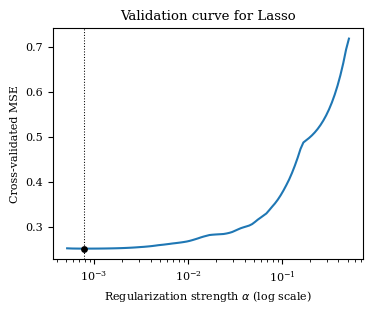

In [33]:
import matplotlib.pyplot as plt

# Recover grid of alphas used for CV
alphas = lcv.alphas_

# Plot MSE against alphas, highlight minimum MSE
plt.plot(alphas, mse_mean)
plt.xlabel(r'Regularization strength $\alpha$ (log scale)')
plt.ylabel('Cross-validated MSE')
plt.scatter(alphas[imin], mse_mean[imin], s=15, c='black', zorder=100)
plt.axvline(alphas[imin], ls=':', lw=0.75, c='black')
plt.xscale('log')
_ = plt.title('Validation curve for Lasso')

Now that we have identified the optimal $\alpha$, we can re-fit the Lasso and plot the prediction from this model.

In [34]:
# Create pipeline with Lasso using optimal alpha
pipe_lasso = make_pipeline(
    PolynomialFeatures(
        degree=degree, 
        include_bias=False
    ),
    StandardScaler(),
    Lasso(alpha=alpha_best, fit_intercept=True, max_iter=100000)
)

pipe_lasso.fit(x[:, None], y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('polynomialfeatures', ...), ('standardscaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"degree degree: int or tuple (min_degree, max_degree), default=2If a single int is given, it specifies the maximal degree of thepolynomial features. If a tuple `(min_degree, max_degree)` is passed,then `min_degree` is the minimum and `max_degree` is the maximumpolynomial degree of the generated features. Note that `min_degree=0`and `min_degree=1` are equivalent as outputting the degree zero term isdetermined by `include_bias`.",15
,"interaction_only interaction_only: bool, default=FalseIf `True`, only interaction features are produced: features that areproducts of at most `degree` *distinct* input features, i.e. terms withpower of 2 or higher of the same input feature are excluded:- included: `x[0]`, `x[1]`, `x[0] * x[1]`, etc.- excluded: `x[0] ** 2`, `x[0] ** 2 * x[1]`, etc.",False
,"include_bias include_bias: bool, default=TrueIf `True` (default), then include a bias column, the feature in whichall polynomial powers are zero (i.e. a column of ones - acts as anintercept term in a linear model).",False
,"order order: {'C', 'F'}, default='C'Order of output array in the dense case. `'F'` order is faster tocompute, but may slow down subsequent estimators... versionadded:: 0.21",'C'
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


Finally, we visually compare the true model to the Lasso prediction using the optimal value of $\alpha$.

In [35]:
# Grid on which to evaluate predictions
xvalues = np.linspace(np.amin(x), np.amax(x), 100)

# Predicted values from Lasso regression
y_pred = pipe_lasso.predict(xvalues[:, None])

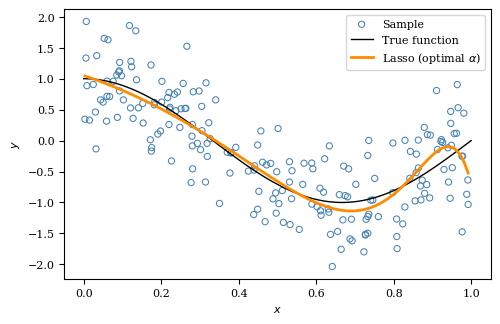

In [36]:
# Plot sample and true relationship
ax = plot_trig_sample(x, y)

# Plot prediction from optimal Lasso model
plt.plot(xvalues, y_pred, c='darkorange', lw=2.0, label=r'Lasso (optimal $\alpha$)')
    
_ = plt.legend()